# Quantification of Events' Similarity:
### __Description of the Test Statistic__:
In order to improve modeling efficency and reduce redundancy, incremental excess rainfall (runoff) curves are grouped using a novel test statistic. This test statistic is a quantitative measure of the similiarity between two curves and is based on the incremental and cumulative volumentric differences between the two curves. The mathematical structure of the test statistic is based on the Kling-Gupta Efficiency described in Kling et al. (2012) and can be expressed as a follows:

$$
test = 1-\sqrt{(t_c-1)^2+(t_v-1)^2}
$$

Where, 
$$
t_c=  \frac{conEpsilon-max⁡\%dif}{conEpsilon}
$$

and

$$
t_v= \frac{volEpsilon-total⁡\%dif}{volEpsilon}
$$


For $t_c$, the $max\%dif$ is the maximum percent difference in runoff between two curves at any given timestep, where the length of the timestep is set by $tempEpsilon$. This percent difference can be expressed as:

$$
\%dif =  \frac{\mid R_{1_i}-R_{2_i}\mid}{\Big[\frac{R_{1_i}+R_{2_i}}{2}\Big]} *100
$$

Where, $R_{1_i}$ is the runoff over timestep $i$ for curve 1 and $R_{2_i}$ is the runoff over time step $i$ for curve 2.


For $t_v$, the $total \% dif$ is the percent difference in the total runoff between two curves. This percent difference can be expressed as:

$$
𝑡𝑜𝑡𝑎𝑙 \% 𝑑𝑖𝑓=  \frac{T_1-T_2}{\Big[\frac{T_1+T_2}{2}\Big]} *100
$$

Where, $T_1$ is the total runoff for curve 1 and is $T_2$ is the total runoff for curve 2.

### __Test Statistic Parameters__:

- __tempEpsilon__: The number of hours over which to resample the excess rainfall event time-series during the first convolution. This smooths-out high temporal frequency variability, which means more curves will be considered similiar to eachother. 

- __tempEpsilon2__: The tempEpsilon for the final (second) convolution. 

- __convEpsilon__: The maximum allowable percent difference in excess rainfall between two curves at any timestep. If $max⁡\%dif$ is greater than or equal to $conEpsilon$ then $t_c$ will be less than or equal to zero, resulting in a test value that is less than or equal to zero (see `Interpretation of the Test Statistic` below).

- __volEpsilon__: The maximum allowable precent difference in the total excess rainfall between two curves. If $total⁡\%dif$ is greater than or equal to $volEpsilon$ then $t_v$ will be less than or equal to zero, resulting in a test value that is less than or equal to zero (see `Interpretation of the Test Statistic` below).



#Show a plot of each here
### Visualize the test statistic parameters:

##### Load dependencies:

In [2]:
import sys
sys.path.append('core')
from hydromet import*

file = 'DC_P01.json'
duration = 24 # Hours
BCN = 'D01'
root_dir = pl.Path(os.getcwd())
output_dir = root_dir/'Outputs'

with open(output_dir/file) as f:
    EventsTable = json.load(f)
dur =  'H{}'.format(str(duration).zfill(2))
events = pd.DataFrame.from_dict(EventsTable[dur]['BCName'][BCN])
events['hours'] = EventsTable[dur]['time_idx']
events = events.set_index('hours')
events.head(2)

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,...,E2422,E2423,E2424,E2425,E2426,E2427,E2428,E2429,E2430,E2431
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.045131,0.030766,0.021614,0.006797,0.085396,0.018648,0.10523,0.08901,0.011862,0.013333,...,0.00262,0.001364,0.024122,0.083508,0.005366,0.002281,0.046863,0.078757,1.510144,1.875603


##### __tempEpsilon__:
- Convert the tempEpsilon from hours to the number of timesteps.
- Resample the excess rainfall events using the specified number of timesteps
- Plot the results

2 hours is 1 timesteps


ValueError: x and y must have same first dimension, but have shapes (13,) and (14,)

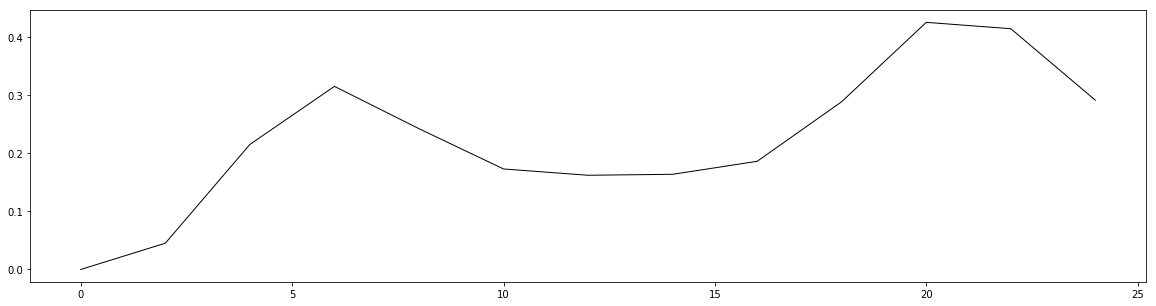

In [84]:
tempEpsilon = [2] 

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(events.index, events.iloc[:,0] , color='black', linewidth='1', label='Original')    
for e in tempEpsilon:
    adj_tempEpsilon = convert_tempEpsilon(e, events)
    print('{0} hours is {1} timesteps'.format(e, adj_tempEpsilon))
    tstep = events.index[-1]/(events.shape[0]-1)
    events_resampled = prep_data_for_convolution(events, adj_tempEpsilon)
    idx = np.arange(0, duration+adj_tempEpsilon*tstep, adj_tempEpsilon*tstep)
    ax.plot(idx, np.insert(list(events_resampled.iloc[:,0]), 0, 0), linewidth='1', label='tempEpsilon = {}'.format(e), alpha=0.75)    
ax.grid()
ax.set_xlabel('Duration, [hours]')
ax.set_ylabel('Runoff, [inches/timestep]')
ax.set_title('Excess Rainfall', size = 18)
ax.legend() 

In [86]:
def prep_data_for_convolution(dataslice: pd.DataFrame, 
                                    adj_tempEpsilon: int) -> pd.DataFrame:
    '''The runoff for each column (event) in the passed dataframe is 
       calculated from zero to 24 hours for the intervals of length 
       tempEpsilon*timstep (30 minutes).
    '''
    curve_test_dict = {}
    for col in dataslice.columns:   
        curve_result = test_shapes(dataslice, col, adj_tempEpsilon) 
        curve_test_dict[col] = curve_result
    curve_test_df = pd.DataFrame.from_dict(curve_test_dict, orient='index').T
    curve_test_df_nanzero = curve_test_df.fillna(0)
    return curve_test_df_nanzero


def test_shapes(dataslice: pd.DataFrame, col: str, 
                                adj_tempEpsilon: int) -> Array[np.float64]:
    '''Calculates the total runoff for each interval, where the interval 
       width is equal to tempEpsilon times the timestep (30 minutes).
    '''
    calc_sum = []
    for i in np.arange(0, len(dataslice.index), adj_tempEpsilon):
        calc_sum.append(sum(dataslice.iloc[i:i+1][col]))
    curve_shape = np.array(calc_sum)
    return curve_shape

In [90]:
calc_sum = test_shapes(events, 'E2001', 2)

In [93]:
sum(calc_sum)

0.7189336534485942

In [92]:
sum(events_resampled.iloc[:,0])

2.9192874546119274

In [95]:
for i in np.arange(0, len(events.index), adj_tempEpsilon):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12


##### __conEpsilon__:

In [9]:
convEpsilon = 133.33  

##### __volEpsilon__:

In [ ]:

volEpsilon = 67  

#### __Interpretion of the Test Statistic__:
As described above, the test statistic is a quantitative measure of the similiarity between two incremental excess rainfall curves, where:
- __1__ -- indicates that the resampled curves are identical to each other. Note that the curves are resampled using either $tempEpsilon$ or $tempEpsilon2$ depending on if the test statistic is being calculated during the first or final (second) convolution.
   - This occurs when both $max⁡\%dif$ and $total⁡\%dif$ are equal to zero, such that $t_c$ and $t_v$ are equal to one.
- __0__ -- indicates that the curves are not identical (being conservative). 
    - This occurs when either the $max⁡\%dif$  is equal to $conEpsilon$ or $total⁡\%dif$ is equal to $volEpsilon$, such that either $t_c$ or $t_v$ is equal to zero. 
    - Note that using zero as the threshold for when two curves are no longer considered similiar is conservative since one of the two $\%dif$ values are still less the user defined conEpsilon or volEpsilon value. 
- __1-√2__ -- the max⁡〖% 𝑑𝑖𝑓〗 is equal to 𝑐𝑜𝑛𝐸𝑝𝑠𝑖𝑙𝑜𝑛 and  total⁡〖% 𝑑𝑖𝑓〗 is equal to 𝑣𝑜𝑙𝐸𝑝𝑠𝑖𝑙𝑜𝑛. Again, using the parameters as measures of it, this implies the curves are not equal with respect to either parameter. Note that 𝑡_𝑐=𝑡_𝑣=0


In [ ]:
tc = np.arange(-1,1,0.1)
tv = np.arange(-1,1,0.1)

test= [] 
for i in tc:
    for j in tv:
        t = 1-np.sqrt((i-1)**2+(j-1)**2)
        test.append((i, j ,t))

In [98]:
x = np.arange(1,41)

v1 = 1.0

for i in x:
    v2 = i
    pdiff = np.abs(v1-v2)/((v1+v2)/2)*100.0
    print('Value1 is {}x value2,'.format(i), 'Epsilon:',np.around(pdiff,2))

Value1 is 1x value2, Epsilon: 0.0
Value1 is 2x value2, Epsilon: 66.67
Value1 is 3x value2, Epsilon: 100.0
Value1 is 4x value2, Epsilon: 120.0
Value1 is 5x value2, Epsilon: 133.33
Value1 is 6x value2, Epsilon: 142.86
Value1 is 7x value2, Epsilon: 150.0
Value1 is 8x value2, Epsilon: 155.56
Value1 is 9x value2, Epsilon: 160.0
Value1 is 10x value2, Epsilon: 163.64
Value1 is 11x value2, Epsilon: 166.67
Value1 is 12x value2, Epsilon: 169.23
Value1 is 13x value2, Epsilon: 171.43
Value1 is 14x value2, Epsilon: 173.33
Value1 is 15x value2, Epsilon: 175.0
Value1 is 16x value2, Epsilon: 176.47
Value1 is 17x value2, Epsilon: 177.78
Value1 is 18x value2, Epsilon: 178.95
Value1 is 19x value2, Epsilon: 180.0
Value1 is 20x value2, Epsilon: 180.95
Value1 is 21x value2, Epsilon: 181.82
Value1 is 22x value2, Epsilon: 182.61
Value1 is 23x value2, Epsilon: 183.33
Value1 is 24x value2, Epsilon: 184.0
Value1 is 25x value2, Epsilon: 184.62
Value1 is 26x value2, Epsilon: 185.19
Value1 is 27x value2, Epsilon: 1

---

# End